Note: Pls change the directory of file paths as your dataset, checkpoint locaiton, result location.

In [2]:
# prompt: connect with google drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import json
import numpy as np # Import the numpy library



In [4]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/TwitterDataset/twitter_training.csv", header=None)
df.columns = ["id", "entity", "sentiment", "tweet"]
df = df[["sentiment", "tweet"]]

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

df["tweet"] = df["tweet"].apply(clean_text)
df["sentiment"] = df["sentiment"].astype("category")

# Convert labels to numbers
label_mapping = {"Positive": 0, "Neutral": 1, "Negative": 2, "Irrelevant": 3}
df["sentiment"] = df["sentiment"].map(label_mapping)

# Split dataset
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["sentiment"])

# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the data
def tokenize_data(data):
    return tokenizer(data["tweet"].tolist(), padding=True, truncation=True, max_length=128)

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)

# Create a Dataset class
class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TwitterDataset(train_encodings, train_df["sentiment"].tolist())
val_dataset = TwitterDataset(val_encodings, val_df["sentiment"].tolist())

# Load model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:

# Set training arguments with saving checkpoints, logging, and early stopping
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/checkpoints",  # Save checkpoints
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,  # Regularization
    eval_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",  # Save model checkpoints at every epoch
    logging_dir="/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/logs",  # Save logs
    logging_steps=10,  # Log every 10 steps
    evaluation_strategy="epoch",  # Evaluate every epoch
    lr_scheduler_type="linear",  # Use a linear learning rate scheduler
    learning_rate=2e-5,  # Set a lower learning rate to prevent overfitting
    save_total_limit=3,  # Keep only the last 3 checkpoints
    metric_for_best_model="eval_loss",  # Track best model based on validation loss
    load_best_model_at_end=True,  # Load best model after training
    report_to="none",  # Disable W&B logging
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [6]:
# Implement early stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # Stop after 2 epochs without improvement

# Define Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(axis=-1) == p.label_ids).mean(),
    },
    callbacks=[early_stopping],  # Add early stopping callback
)

# Train the model
trainer.train()

# Save the final model
trainer.save_model("/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/final_model")


<ipython-input-6-2788a88a0f3b>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.805800,0.706112,0.725581
2,0.469600,0.477129,0.827877
3,0.229400,0.383818,0.871460
4,0.150600,0.380495,0.881502
5,0.111400,0.384090,0.887059


In [7]:
# Evaluate the model
eval_results = trainer.evaluate()

# Save evaluation results
with open("/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/eval_results.json", "w") as f:
    json.dump(eval_results, f, indent=4)

print(f"Final Evaluation: {eval_results}")

# Load trained model for testing
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/foundation of ai/GroupAssignment/final_model")
model.to(device)
model.eval()

# Function to make predictions
def predict_sentiment(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    reverse_mapping = {0: "Positive", 1: "Neutral", 2: "Negative", 3: "Irrelevant"}
    return [reverse_mapping[pred] for pred in predictions]

# Test with 3 example texts
test_texts = [
    "I love this new phone! The camera quality is amazing!",
    "The weather today is okay, not too hot or cold.",
    "I hate waiting in long lines at the grocery store."
]

predicted_sentiments = predict_sentiment(test_texts)

# Print test results
for text, sentiment in zip(test_texts, predicted_sentiments):
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

Final Evaluation: {'eval_loss': 0.3804952800273895, 'eval_accuracy': 0.8815023097007432, 'eval_runtime': 40.7825, 'eval_samples_per_second': 366.26, 'eval_steps_per_second': 11.451, 'epoch': 5.0}
Text: I love this new phone! The camera quality is amazing!
Predicted Sentiment: Positive

Text: The weather today is okay, not too hot or cold.
Predicted Sentiment: Neutral

Text: I hate waiting in long lines at the grocery store.
Predicted Sentiment: Negative




Classification Report:
               precision    recall  f1-score   support

    Positive       0.87      0.89      0.88      4166
     Neutral       0.85      0.88      0.86      3664
    Negative       0.92      0.89      0.91      4509
  Irrelevant       0.88      0.85      0.87      2598

    accuracy                           0.88     14937
   macro avg       0.88      0.88      0.88     14937
weighted avg       0.88      0.88      0.88     14937



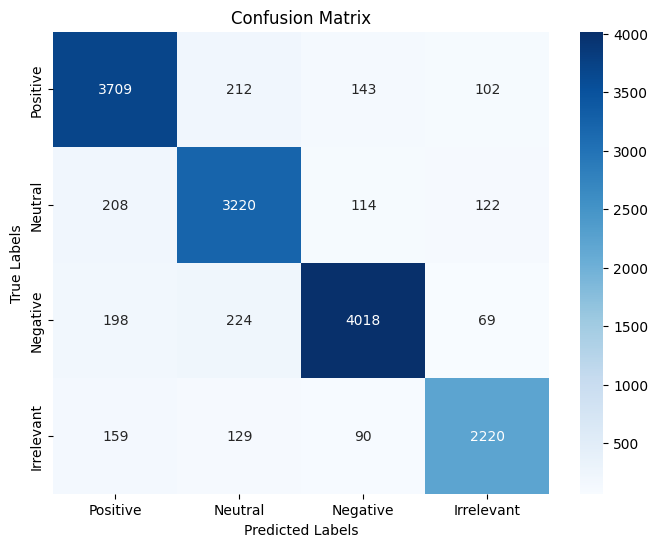

In [12]:
# Get predictions for the entire validation dataset
def get_predictions(model, tokenizer, dataset, label_mapping):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    for batch in torch.utils.data.DataLoader(dataset, batch_size=32):
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        with torch.no_grad():  # Disable gradient calculation
            outputs = model(**inputs)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = labels.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels
predictions, labels = get_predictions(model, tokenizer, val_dataset, label_mapping)

# Compute classification report (Precision, Recall, F1-Score, Support)
report = classification_report(labels, predictions, target_names=label_mapping.keys())
print("\nClassification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Function to predict sentiment for custom text
def predict_sentiment(text, model, tokenizer, label_mapping):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    sentiment = [k for k, v in label_mapping.items() if v == pred][0]  # Convert prediction back to sentiment label
    return sentiment




In [30]:
# Example: Make prediction with custom text
custom_texts = [
    "I love this product! It's amazing.",
    "I'm not sure if I like this. It's kind of mid.",
    "what the fuck, what did u do to me, i love you fool"
]

for text in custom_texts:
    sentiment = predict_sentiment(text, model, tokenizer, label_mapping)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")

Text: I love this product! It's amazing.
Predicted Sentiment: Positive

Text: I'm not sure if I like this. It's kind of mid.
Predicted Sentiment: Neutral

Text: what the fuck, what did u do to me, i love you fool
Predicted Sentiment: Irrelevant

